## Loading Data to test the models

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# --- 1. Load R-exported data ---
X_train = pd.read_csv("X_train.csv").values.astype(np.float32)
X_test  = pd.read_csv("X_test.csv").values.astype(np.float32)
y_train = pd.read_csv("y_train.csv")["y"].values.astype(np.float32)
y_test  = pd.read_csv("y_test.csv")["y"].values.astype(np.float32)

# Convert to torch tensors
X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train).unsqueeze(1)
X_test_torch  = torch.tensor(X_test)
y_test_torch  = torch.tensor(y_test).unsqueeze(1)

## Mixture of regression models

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

# Define a dense linear layer without sparsity
class DenseLinear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)  # Standard linear layer
    
    def forward(self, x):
        return self.linear(x)  # Apply linear transformation

# Define the Mixture of Regressions (MoR) model without sparsity
class MixtureOfRegressions(nn.Module):
    def __init__(self, input_dim, output_dim, num_experts=3):
        super().__init__()
        self.num_experts = num_experts  # Number of experts
        self.gate_weights = nn.Parameter(torch.ones(num_experts) / num_experts)  # Fixed proportions
        
        # Create a list of dense linear experts
        self.experts = nn.ModuleList([DenseLinear(input_dim, output_dim) for _ in range(num_experts)])
    
    def forward(self, x):
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # Compute outputs from all experts
        output = torch.sum(self.gate_weights.unsqueeze(0).unsqueeze(-1) * expert_outputs, dim=1)  # Weighted sum of expert outputs
        return output

In [19]:

# Define model
input_dim = X_train.shape[1]
output_dim = 1
num_experts = 3

model = MixtureOfRegressions(input_dim, output_dim, num_experts)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f}")

Epoch 0 | Train Loss: 183.3779
Epoch 20 | Train Loss: 152.3035
Epoch 40 | Train Loss: 115.1224
Epoch 60 | Train Loss: 92.4018
Epoch 80 | Train Loss: 80.9116
Epoch 100 | Train Loss: 72.9314
Epoch 120 | Train Loss: 69.0211
Epoch 140 | Train Loss: 67.3347
Epoch 160 | Train Loss: 66.4013
Epoch 180 | Train Loss: 65.7318
Epoch 200 | Train Loss: 65.1250
Epoch 220 | Train Loss: 64.5159
Epoch 240 | Train Loss: 63.8864
Epoch 260 | Train Loss: 63.2270
Epoch 280 | Train Loss: 62.5310
Epoch 300 | Train Loss: 61.7932
Epoch 320 | Train Loss: 61.0098
Epoch 340 | Train Loss: 60.1795
Epoch 360 | Train Loss: 59.3038
Epoch 380 | Train Loss: 58.3885
Epoch 400 | Train Loss: 57.4446
Epoch 420 | Train Loss: 56.4883
Epoch 440 | Train Loss: 55.5406
Epoch 460 | Train Loss: 54.6252
Epoch 480 | Train Loss: 53.7663
Epoch 500 | Train Loss: 53.2200
Epoch 520 | Train Loss: 52.3394
Epoch 540 | Train Loss: 51.7728
Epoch 560 | Train Loss: 51.3038
Epoch 580 | Train Loss: 50.9274
Epoch 600 | Train Loss: 50.6350
Epoch 620 |

In [20]:

##
with torch.no_grad():
    y_train_pred = model(X_train_torch).squeeze().numpy()
    y_test_pred = model(X_test_torch).squeeze().numpy()

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n✅ Mixture of Regressions:")
print(f"Train MSE: {mse_train:.4f}")
print(f"Test  MSE: {mse_test:.4f}")


✅ Mixture of Regressions:
Train MSE: 49.9341
Test  MSE: 47.3176


### Sparse MoE


In [7]:
class SparseMixtureOfRegressions(nn.Module):
    def __init__(self, input_dim, output_dim, num_experts=3):
        super().__init__()
        self.num_experts = num_experts
        self.gate_weights = nn.Parameter(torch.ones(num_experts) / num_experts)  # fixed/uniform gate
        self.experts = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(num_experts)])
    
    def forward(self, x):
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        output = torch.sum(self.gate_weights.unsqueeze(0).unsqueeze(-1) * expert_outputs, dim=1)
        return output

    def l1_penalty(self):
        return sum(torch.sum(torch.abs(expert.weight)) for expert in self.experts)

In [8]:
def train_sparse_moe(model, X_train, y_train, X_test, y_test, 
                     n_epochs=200, lr=1e-2, l1_lambda=1e-2):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train) + l1_lambda * model.l1_penalty()
        loss.backward()
        optimizer.step()
        
        if epoch % 20 == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train).squeeze().numpy()
        y_test_pred = model(X_test).squeeze().numpy()
    
    mse_train = mean_squared_error(y_train.squeeze().numpy(), y_train_pred)
    mse_test = mean_squared_error(y_test.squeeze().numpy(), y_test_pred)
    
    return mse_train, mse_test, y_train_pred, y_test_pred

In [10]:
# Assume you've already loaded the CSV data into:
# X_train_torch, y_train_torch, X_test_torch, y_test_torch

input_dim = X_train.shape[1]
output_dim = 1
num_experts = 3

sparse_model = SparseMixtureOfRegressions(input_dim, output_dim, num_experts)

mse_train, mse_test, y_hat_train, y_hat_test = train_sparse_moe(
    model=sparse_model,
    X_train=X_train_torch,
    y_train=y_train_torch,
    X_test=X_test_torch,
    y_test=y_test_torch,
    n_epochs=1500,
    lr=0.01,
    l1_lambda=3e-2  # adjust this to control sparsity
)

print("\n✅ Sparse MoE Results:")
print(f"Train MSE: {mse_train:.4f}")
print(f"Test  MSE: {mse_test:.4f}")

Epoch 0 | Loss: 181.8892
Epoch 20 | Loss: 153.6752
Epoch 40 | Loss: 114.9617
Epoch 60 | Loss: 92.8907
Epoch 80 | Loss: 83.4187
Epoch 100 | Loss: 76.1542
Epoch 120 | Loss: 71.8966
Epoch 140 | Loss: 69.6353
Epoch 160 | Loss: 68.2114
Epoch 180 | Loss: 67.1955
Epoch 200 | Loss: 66.4325
Epoch 220 | Loss: 65.7945
Epoch 240 | Loss: 65.1990
Epoch 260 | Loss: 64.6022
Epoch 280 | Loss: 63.9838
Epoch 300 | Loss: 63.3341
Epoch 320 | Loss: 62.6490
Epoch 340 | Loss: 61.9247
Epoch 360 | Loss: 61.1594
Epoch 380 | Loss: 60.3535
Epoch 400 | Loss: 59.5097
Epoch 420 | Loss: 58.6339
Epoch 440 | Loss: 57.7357
Epoch 460 | Loss: 56.8284
Epoch 480 | Loss: 55.9290
Epoch 500 | Loss: 55.0567
Epoch 520 | Loss: 54.2316
Epoch 540 | Loss: 53.4710
Epoch 560 | Loss: 52.7884
Epoch 580 | Loss: 52.2022
Epoch 600 | Loss: 51.7202
Epoch 620 | Loss: 51.3130
Epoch 640 | Loss: 50.9909
Epoch 660 | Loss: 50.7398
Epoch 680 | Loss: 50.8327
Epoch 700 | Loss: 50.4158
Epoch 720 | Loss: 50.3183
Epoch 740 | Loss: 50.2489
Epoch 760 | Los

### Winner Take All Sparse MoE

In [11]:
class WTASparseMoE(nn.Module):
    def __init__(self, input_dim, output_dim, num_experts=3):
        super().__init__()
        self.num_experts = num_experts
        self.gate = nn.Linear(input_dim, num_experts)  # can be simple linear
        self.experts = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(num_experts)])
    
    def forward(self, x):
        gate_scores = self.gate(x)  # (batch, num_experts)
        winner_idx = gate_scores.argmax(dim=1)  # (batch,)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # (batch, num_experts, 1)
        output = expert_outputs[torch.arange(x.size(0)), winner_idx, :]  # select only the winning expert
        return output
    
    def l1_penalty(self):
        return sum(torch.sum(torch.abs(expert.weight)) for expert in self.experts)

In [12]:
def train_wta_sparse_moe(model, X_train, y_train, X_test, y_test, 
                         n_epochs=300, lr=1e-2, l1_lambda=1e-2):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train) + l1_lambda * model.l1_penalty()
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train).squeeze().numpy()
        y_test_pred = model(X_test).squeeze().numpy()

    mse_train = mean_squared_error(y_train.squeeze().numpy(), y_train_pred)
    mse_test = mean_squared_error(y_test.squeeze().numpy(), y_test_pred)

    return mse_train, mse_test, y_train_pred, y_test_pred

In [14]:
wta_sparse_model = WTASparseMoE(input_dim, output_dim, num_experts=3)

mse_train_ws, mse_test_ws, y_hat_train_ws, y_hat_test_ws = train_wta_sparse_moe(
    model=wta_sparse_model,
    X_train=X_train_torch,
    y_train=y_train_torch,
    X_test=X_test_torch,
    y_test=y_test_torch,
    n_epochs=1500,
    lr=0.01,
    l1_lambda=1e-2  # tune this!
)

print("\n🥇🔪 WTA Sparse MoE:")
print(f"Train MSE: {mse_train_ws:.4f}")
print(f"Test  MSE: {mse_test_ws:.4f}")

Epoch 0 | Loss: 187.6604
Epoch 20 | Loss: 138.5585
Epoch 40 | Loss: 122.2521
Epoch 60 | Loss: 111.8336
Epoch 80 | Loss: 103.1450
Epoch 100 | Loss: 96.0515
Epoch 120 | Loss: 90.3431
Epoch 140 | Loss: 85.7796
Epoch 160 | Loss: 82.1260
Epoch 180 | Loss: 79.1713
Epoch 200 | Loss: 76.7439
Epoch 220 | Loss: 74.7122
Epoch 240 | Loss: 72.9805
Epoch 260 | Loss: 71.4815
Epoch 280 | Loss: 70.1686
Epoch 300 | Loss: 69.0097
Epoch 320 | Loss: 67.9819
Epoch 340 | Loss: 67.0685
Epoch 360 | Loss: 66.2561
Epoch 380 | Loss: 65.5340
Epoch 400 | Loss: 64.8921
Epoch 420 | Loss: 64.3214
Epoch 440 | Loss: 63.8139
Epoch 460 | Loss: 63.3621
Epoch 480 | Loss: 62.9591
Epoch 500 | Loss: 62.5991
Epoch 520 | Loss: 62.2764
Epoch 540 | Loss: 61.9859
Epoch 560 | Loss: 61.7231
Epoch 580 | Loss: 61.4841
Epoch 600 | Loss: 61.2654
Epoch 620 | Loss: 61.0640
Epoch 640 | Loss: 60.8773
Epoch 660 | Loss: 60.7031
Epoch 680 | Loss: 60.5394
Epoch 700 | Loss: 60.3846
Epoch 720 | Loss: 60.2372
Epoch 740 | Loss: 60.0961
Epoch 760 | L

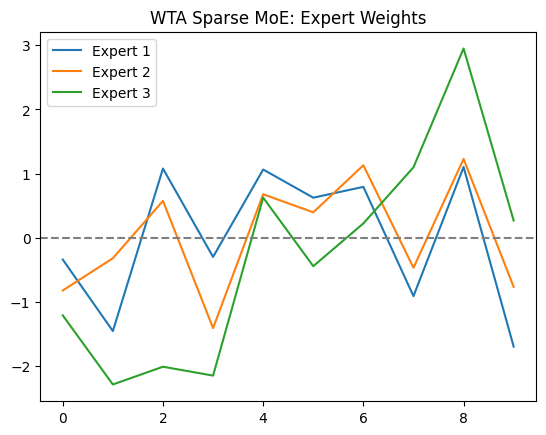

In [15]:
for i, expert in enumerate(wta_sparse_model.experts):
    plt.plot(expert.weight.detach().cpu().numpy().flatten(), label=f"Expert {i+1}")
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title("WTA Sparse MoE: Expert Weights")
plt.show()

## MoEBIUS in pytorch